# NCSU GIS/MEA582: Flow Modeling

In [1]:
import sys
v = sys.version_info
print(f"We are using Python {v.major}.{v.minor}.{v.micro}")

We are using Python 3.10.6


In [2]:
!grass -c -e ~/Documents/grassdata/nc_spm_08_grass7/HW_7A_Flow_Modeling

Creating new GRASS GIS mapset <HW_7A_Flow_Modeling>...


In [3]:
# Import Python standard library and IPython packages we need.
import subprocess
import sys
import matplotlib.pyplot as plt
from PIL import Image


# Ask GRASS GIS where its Python packages are.
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

# Import the GRASS GIS packages we need.
import grass.script as gs
import grass.jupyter as gj

# Start GRASS Session
session = gj.init("~/Documents/grassdata", "nc_spm_08_grass7", "HW_7A_Flow_Modeling")

In [4]:
%%bash
curl -o "inputs/outlet_point.txt" "http://ncsu-geoforall-lab.github.io/geospatial-modeling-course/grass/data/outlet_point.txt"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    21  100    21    0     0    315      0 --:--:-- --:--:-- --:--:--   318


## Compute flow direction, flow accumulation and subwatersheds

 Compute flow direction, flow accumulation and subwatersheds with approx. size of 10000 cells from 30m NED.

In [78]:
%%bash
g.region raster=elev_ned_30m -p
r.watershed -s elevation=elev_ned_30m threshold=10000 accumulation=accum_10K drainage=draindir_10K basin=basin_10K

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      228500
south:      215000
west:       630000
east:       645000
nsres:      30
ewres:      30
rows:       450
cols:       500
cells:      225000


SECTION 1a (of 5): Initiating Memory.
SECTION 1b (of 5): Determining Offmap Flow.
   0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68  72  76  80  84  88  92  96 100
SECTION 2: A* Search.
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
SECTION 3: Accumulating Surface Flow with SFD.
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 100
SECTION 4: Watershed determination.
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
SECTION 5: Closing Maps.
  12 100


In [91]:
!r.univar accum_10K

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
total null and non-null cells: 225000
total null cells: 0

Of the non-null cells:
----------------------
n: 225000
minimum: -73428
maximum: 37836
range: 111264
mean: -81.4819
mean of absolute values: 224.274
standard deviation: 2618.83
variance: 6.85828e+06
variation coefficient: -3214.01 %
sum: -18333427


Extract more detailed streams from flow accumulation raster: 

In [88]:
!r.mapcalc "streams_der_30m = if(abs(accum_10K) > 100, 1, null())"

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


Convert to vector format and display results along with the official Wake county streams (red): 

In [89]:
%%bash

r.to.vect -s basin_10K output=basin_10K type=area
r.thin streams_der_30m output=streams_der_30m_t
r.to.vect -s streams_der_30m_t out=streams_der_30m type=line

Extracting areas...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Writing areas...
   0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68  72  76  80  84  88  92  96 100
Building topology for vector map <basin_10K@HW_7A_Flow_Modeling>...
Registering primitives...
Building areas...
   0   9  18  27  36  45  54  63  72  81  90 100
Attaching islands...
   0 100
Attaching centroids...
   0  20  40  60  80 100
r.to.vect complete.
Raster map <streams_der_30m> - 450 rows X 500 columns
Bounding box: l = 2, r = 501, t = 2, b = 451
Pass number 1
Deleted 439 pixels
Pass number 2
Deleted 1 pixel
Pass number 3
Deleted 0 pixels
Thinning completed successfully.
Output map 450 rows X 500 columns
Window 450 rows X 500 columns
         overwritten
Extracting lines...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  9

Generate shaded map and display: \
**How do the derived streams compare with the official stream map?** \
**How can you modify the mapcalc expression to make stream origins fit better with the official stream map?**

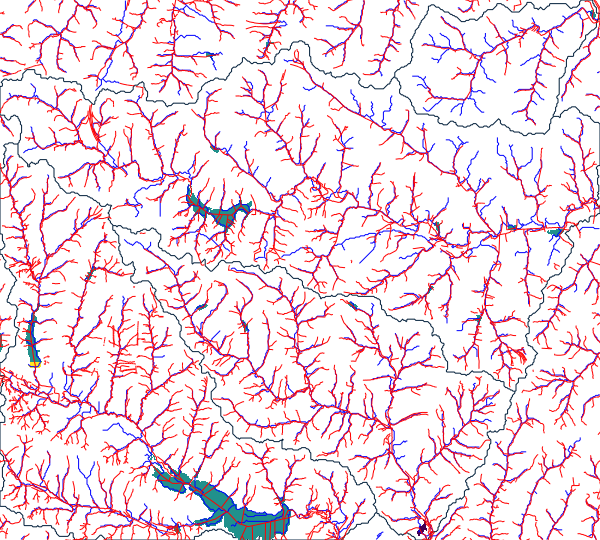

In [90]:
# Create Map instance
mystream_map = gj.Map(filename="output/mystream.png")
# Add the elevation raster to the map
mystream_map.d_vect(map="basin_10K", type="boundary")
mystream_map.d_rast(map="lakes")
mystream_map.d_vect(map="streams_der_30m", color="blue")
mystream_map.d_vect(map="streams", color="red")

# Display map
mystream_map.show()

## Create map of DEM depressions

Depression filling is often necessary for certain flow routing algorithms but it can alter the elevation data significantly. Find out how extensive the depressions are in our DEM. \

> Note that r.watershed doesn't need any depression filling thanks to its underlying algorithm which uses least cost path to get over depressions.

In [9]:
%%bash
g.region raster=elevation -p
r.fill.dir input=elevation output=elev_fill1 direction=dir1 areas=unres1
r.fill.dir input=elev_fill1 output=elev_fill2 direction=dir2 areas=unres2
r.fill.dir input=elev_fill2 output=elev_fill3 direction=dir3 areas=unres3
r.mapcalc "depr_bin = if((elevation-elev_fill3) < 0., 1, null())"
r.colors depr_bin color=blues

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      228500
south:      215000
west:       630000
east:       645000
nsres:      10
ewres:      10
rows:       1350
cols:       1500
cells:      2025000


Reading input elevation raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Filling sinks...
Determining flow directions for ambiguous cases...
Found 7944 unresolved areas
Repeat to get the final directions...
Found 1013 unresolved areas
Writing output raster maps...
   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 100
Reading input elevation raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Filling sinks...
Determining flow directions for ambiguous cases...
Found 1013 unresolved areas
Repeat to get the final directions...
Found 93 unresolved areas
Writing output raster maps...
   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 100
Reading input elevation raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54

Remove all previously used layers from the Layer Manager and display the new results, compare the derived depressions with actual lakes: 

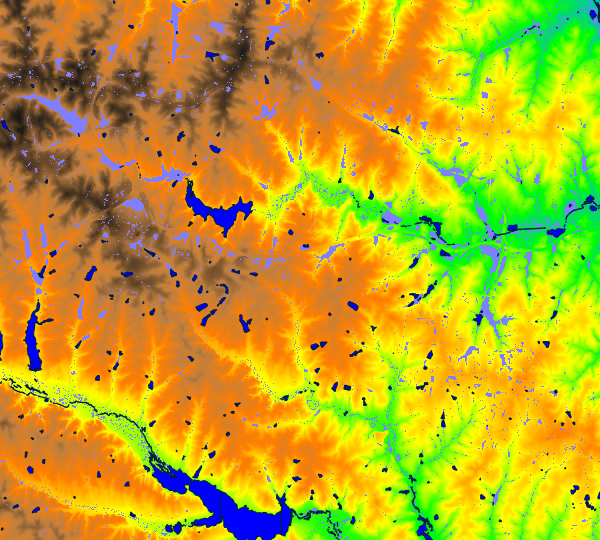

In [10]:
# Create Map instance
depressions_map = gj.Map(filename="output/depressions.png")
# Add the elevation raster to the map
depressions_map.d_rast(map="elevation")
depressions_map.d_rast(map="depr_bin")
depressions_map.d_vect(map="lakes", fill_color="blue", type="area")

# Display map
depressions_map.show()

## Derive contributing area for a given outlet

Set region to the high resolution study area and zoom to it: 

In [11]:
%%bash

g.region rural_1m -p
r.watershed -as elevation=elev_lid792_1m threshold=5000 accumulation=accum_5K drainage=draindir_5K basin=basin_5K

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      220750
south:      220000
west:       638300
east:       639000
nsres:      1
ewres:      1
rows:       750
cols:       700
cells:      525000


SECTION 1a (of 5): Initiating Memory.
SECTION 1b (of 5): Determining Offmap Flow.
   0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68  72  76  80  84  88  92  96 100
SECTION 2: A* Search.
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
SECTION 3: Accumulating Surface Flow with SFD.
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 100
SECTION 4: Watershed determination.
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
SECTION 5: Closing Maps.
 100
Writing out only positive flow accumulation values.
Cells with 

Remove previous layers. Display extracted streams over aerial image: 

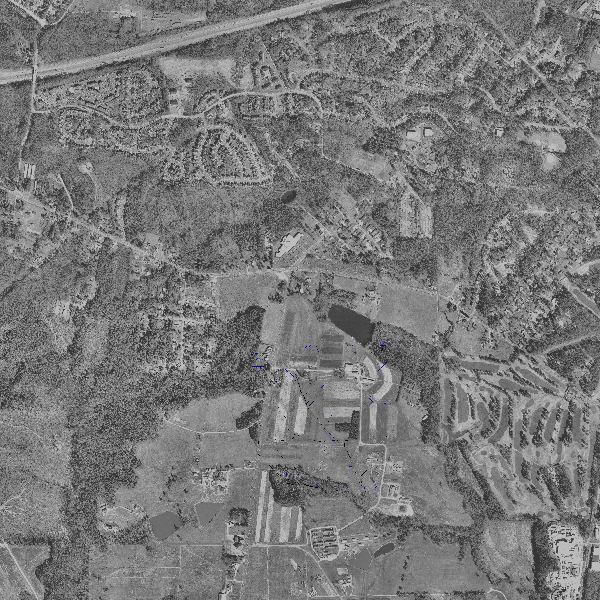

In [12]:
# Create Map instance
accum_5K_map = gj.Map()
# Add the elevation raster to the map
accum_5K_map.d_rast(map="ortho_2001_t792_1m")
accum_5K_map.d_rast(map="accum_5K", values="1500-1000000")

# Display map
accum_5K_map.show()

 Identify outlet on the extracted stream. \
 
 Create a vector map with the point east=638845.52 north=220085.26 (download the text file) that has accum_5K=224510. 

In [15]:
%%bash
v.in.ascii input=inputs/outlet_point.txt output=outletA30 separator=space

Scanning input for column types...
Number of columns: 3
Number of data rows: 1
Importing points...
   0 100
Populating table...
Building topology for vector map <outletA30@HW_7A_Flow_Modeling>...
Registering primitives...


Delineate the contributing area associated with this outlet and convert it to vector format: 

In [16]:
%%bash
r.water.outlet input=draindir_5K output=basin_A30 coordinates=638845.52,220085.26
r.to.vect -s basin_A30 output=basin_A30 type=area

   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 100
Extracting areas...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Writing areas...
   0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68  72  76  80  84  88  92  96 100
Building topology for vector map <basin_A30@HW_7A_Flow_Modeling>...
Registering primitives...
Building areas...
   0 100
Attaching islands...
   0 100
Attaching centroids...
   0 100
r.to.vect complete.


Display watershed boundary along with contours. \
Compute the watershed area (category 1)

In [17]:
%%bash
r.contour elev_lid792_1m output=elev_lid792_cont_1m step=1 minlevel=104
r.report basin_A30 unit=h,a

Reading data...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Displacing data...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Writing vector contours (total levels 28)...
   3   7  10  14  17  21  25  28  32  35  39  42  46  50  53  57  60  64  67  71  75  78  82  85  89  92  96 100
Writing attributes...
Building topology for vector map
<elev_lid792_cont_1m@HW_7A_Flow_Modeling>...
Registering primitives...
Snap lines
Reading features...
Snap vertices Pass 1: select points
   0   4   8  12  15  19  23  26  30  34  38  41  45  49  52  56  60  63  67  71  75  78  82  86  89  93  97 100
Snap vertices Pass 2: assign anchor vertices
   4   9  14  19  24  29  34  39  44  49  54  59  64  69  74  79  84  89  94  99 100
Snap vertices Pass 3: snap to assigned points
   0   4   8  12  15  19  23  26  30  34  38  41  4

+-----------------------------------------------------------------------------+
|                         RASTER MAP CATEGORY REPORT                          |
|LOCATION: nc_spm_08_grass7                           Mon Dec  5 14:23:50 2022|
|-----------------------------------------------------------------------------|
|          north: 220750    east: 639000                                      |
|REGION    south: 220000    west: 638300                                      |
|          res:        1    res:       1                                      |
|-----------------------------------------------------------------------------|
|MASK: none                                                                   |
|-----------------------------------------------------------------------------|
|MAP: Watershed basin (basin_A30 in HW_7A_Flow_Modeling)                      |
|-----------------------------------------------------------------------------|
|                 Category Information  

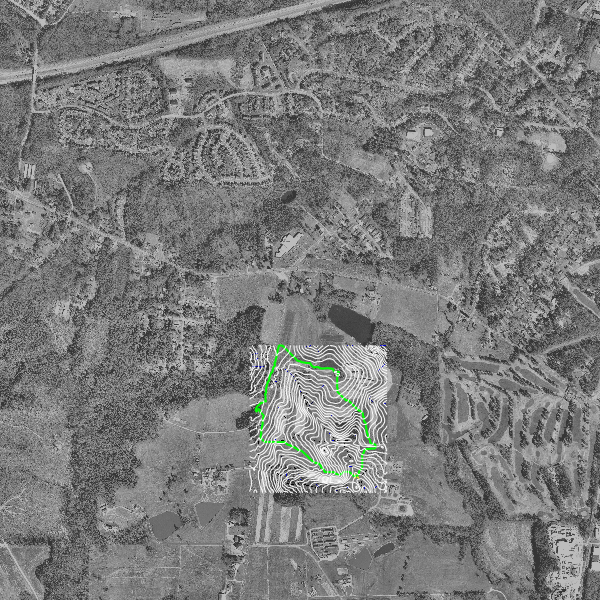

In [20]:
# Create Map instance
watershedA30_map = gj.Map(filename="output/watershedA30.png")\

watershedA30_map.d_rast(map="ortho_2001_t792_1m")
watershedA30_map.d_rast(map="accum_5K", values="1500-1000000")
watershedA30_map.d_vect(map="outletA30", color="yellow")

watershedA30_map.d_vect(map="basin_A30", color="green", type="boundary",width=2)
watershedA30_map.d_vect(map="elev_lid792_cont_1m", color="white")

# Display map
watershedA30_map.show()

## Assess and mitigate impact of the road on flowrouting

 Compare the extracted streams (accum > 1500) with official stream data: 

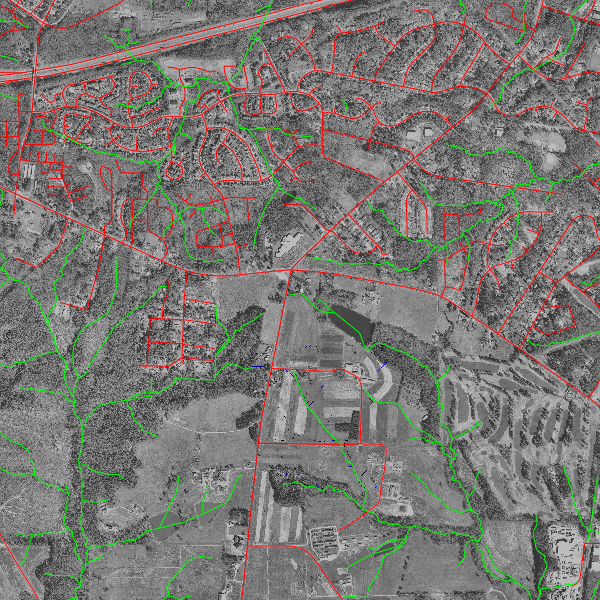

In [22]:
# Create Map instance
streamcompare_map = gj.Map(filename="output/streamcompare.png")\

streamcompare_map.d_rast(map="ortho_2001_t792_1m")
streamcompare_map.d_rast(map="accum_5K", values="1500-1000000")
streamcompare_map.d_vect(map="streets_wake", color="red")

streamcompare_map.d_vect(map="streams", color="green")

# Display map
streamcompare_map.show()

Carve a pre-defined channel given by the stream data into DEM

In [23]:
%%bash
r.carve raster=elev_lid792_1m vector=streams width=2 depth=0.8 output=elev_lidcarved_1m
r.colors elev_lidcarved_1m raster=elev_lid792_1m

Reading raster map...
  10  21  32  43  54  65  76  87  98 100
Processing lines...
  10  21  32  43  54  65  76WARNING: Vect runs out of region and re-enters - this case is not yet
         implemented.
  87  98 100
Writing raster map...
   0  11  22  33  44  55  66  77  88  99Color table for raster map <elev_lidcarved_1m> set to 'elev_lid792_1m'


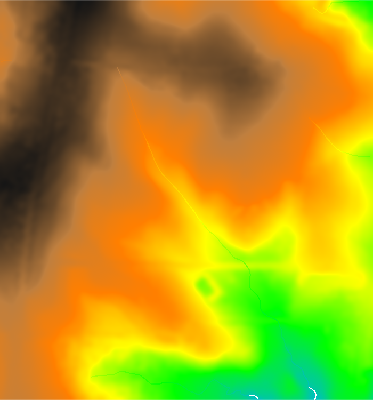

In [24]:
# Create Map instance
elev_lidcarved_1m_map = gj.Map()

elev_lidcarved_1m_map.d_rast(map="elev_lidcarved_1m")

# Display map
elev_lidcarved_1m_map.show()

Extract streams from the carved DEM and compare with the official streams map.

**What is the difference between accum_5K, accumc_5K1m and streams?** \
**Explain the advantage and disadvantage of carving.**

In [25]:
!r.watershed -as elevation=elev_lidcarved_1m accumulation=accumc_5K1m

SECTION 1a (of 4): Initiating Memory.
SECTION 1b (of 4): Determining Offmap Flow.
   0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68  72  76  80  84  88  92  96 100
SECTION 2: A* Search.
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
SECTION 3: Accumulating Surface Flow with SFD.
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 100
SECTION 4: Closing Maps.
Writing out only positive flow accumulation values.
Cells with a likely underestimate for flow accumulation can no longer be
identified.


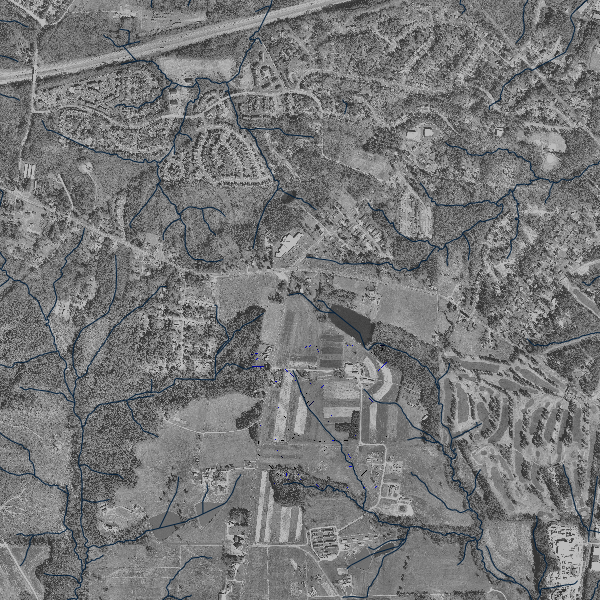

In [27]:
# Create Map instance
streamcarved_map = gj.Map(filename="output/streamcarved.png")\

streamcarved_map.d_rast(map="ortho_2001_t792_1m")
streamcarved_map.d_rast(map="accumc_5K1m", values="1500-1000000")
streamcarved_map.d_vect(map="streams")

# Display map
streamcarved_map.show()

## Compute refined flow pattern using D-inf

Compare upslope and downslope flow lines: **On what type of landform (ridge, valley) they converge?** 

In [28]:
%%bash
g.region raster=elev_lid792_1m -p
r.flow elevation=elev_lid792_1m flowline=flowlines flowlength=flowlg_1m flowaccumulation=flowacc_1m
r.flow -u elevation=elev_lid792_1m flowlength=flowlgup_1m flowaccumulation=flowaccup_1m

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      220750
south:      220000
west:       638300
east:       639000
nsres:      1
ewres:      1
rows:       750
cols:       700
cells:      525000


Reading input raster map <elev_lid792_1m>...
   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 100
Calculating...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Writing output raster map <flowacc_1m>...
   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 100
Building topology for vector map <flowlines@HW_7A_Flow_Modeling>...
Registering primitives...
Reading input raster map <elev_lid792_1m>...
   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 100
Calculating...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Writing output raster map <flowaccup_1m>...
   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 100


Display maps along with contours to see relation to terrain: 

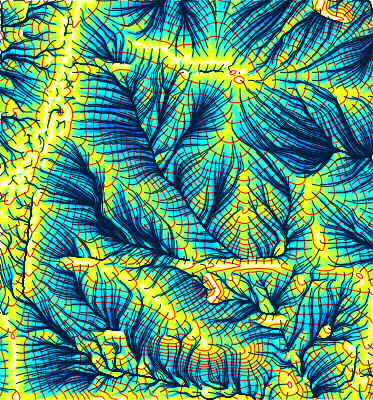

In [29]:
# Create Map instance
flowdown_map = gj.Map(filename="output/flowdown.png")\

flowdown_map.d_rast(map="flowacc_1m")
flowdown_map.d_vect(map="elev_lid792_cont_1m", color="red")
flowdown_map.d_vect(map="flowlines")

# Display map
flowdown_map.show()

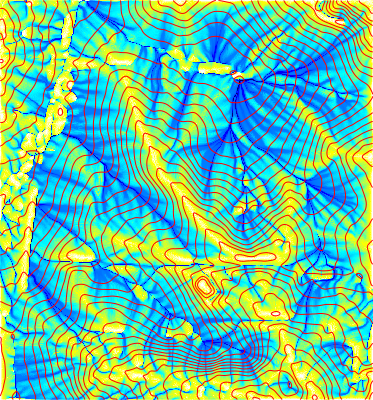

In [30]:
# d.rast flowaccup_1m
# d.vect elev_lid792_cont_1m color=red
# d.out.file flowlines

# Create Map instance
flowlines_map = gj.Map(filename="output/flowlines.png")\

flowlines_map.d_rast(map="flowaccup_1m")
flowlines_map.d_vect(map="elev_lid792_cont_1m", color="red")

# Display map
flowlines_map.show()

## Compare the multiple flow direction result with D8 and Dinf

**Compare the results of r.watershed: accum_5K and accum_mfd_5K1m. Why are they different, which is more accurate and why?**

In [31]:
!r.watershed -a elevation=elev_lid792_1m threshold=5000 accumulation=accum_mfd_5K1m

SECTION 1a (of 5): Initiating Memory.
SECTION 1b (of 5): Determining Offmap Flow.
   0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68  72  76  80  84  88  92  96 100
SECTION 2: A* Search.
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
SECTION 3a: Accumulating Surface Flow with MFD.
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 100
SECTION 3b: Adjusting drainage directions.
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 100
SECTION 4: Watershed determination.
   0   2   4   6   8  10  12  14  16  18  20  22 

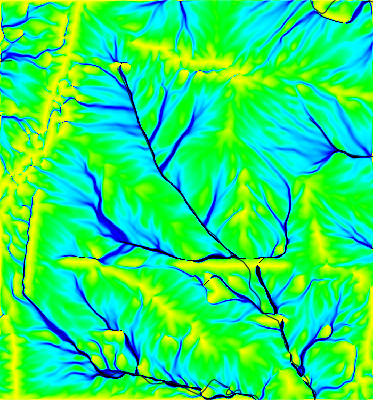

In [32]:
# Create Map instance
stream_mfd_map = gj.Map(filename="output/stream_mfd.png")\

stream_mfd_map.d_rast(map="accum_mfd_5K1m")
stream_mfd_map.d_vect(map="streams")

# Display map
stream_mfd_map.show()

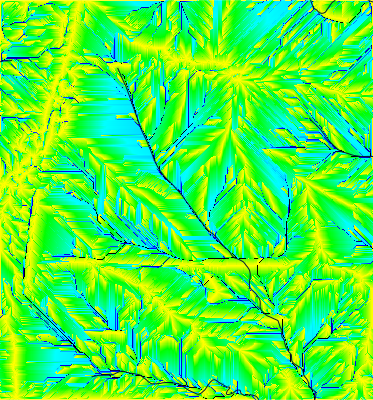

In [ ]:
# Create Map instance
stream_sfd_map = gj.Map(filename="output/stream_sfd.png")\

stream_sfd_map.d_rast(map="accum_5K")
stream_sfd_map.d_vect(map="streams")

# Display map
stream_sfd_map.show()

## Compute wetness index

In [34]:
%%bash
g.region rural_1m -p
r.topidx elev_lid792_1m output=wetness_1m
r.colors map=wetness_1m color=water

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      220750
south:      220000
west:       638300
east:       639000
nsres:      1
ewres:      1
rows:       750
cols:       700
cells:      525000


Reading elevation map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Calculating...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
Number of sinks or boundaries: 53
Writing topographic index map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Color table for raster map <wetness_1m> set to 'water'


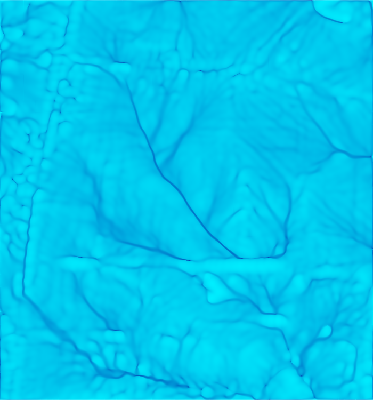

In [35]:
# Create Map instance
wetness_map = gj.Map(filename="output/wetness.png")\

wetness_map.d_rast(map="wetness_1m")

# Display map
wetness_map.show()

Compute the wettness index using the formula in the lecture (hint: you will need to compute slope using elev_lid792_1m and use accum_mfd_5K1m as contributing area. Check the values by comparing your output with wetness_1m computed with r.topidx.

r.topidx creates topographic index (wetness index), ln(a/tan(beta)), map from elevation map

where

    a: the area of the hillslope per unit contour length that drains through any point,

    tan(beta): the local surface topographic slope (delta vertical) / (delta horizontal). 

In [67]:
%%bash
g.region raster=elev_lid792_1m -p
r.slope.aspect elevation=elev_lid792_1m slope=slope
r.mapcalc "wettness_index = log(accum_mfd_5K1m/tan(slope))"
r.colors map=wettness_index color=water

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      220750
south:      220000
west:       638300
east:       639000
nsres:      1
ewres:      1
rows:       750
cols:       700
cells:      525000


   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Slope raster map <slope> complete
Color table for raster map <wettness_index> set to 'water'


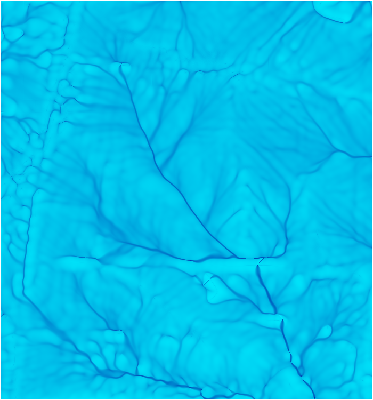

In [68]:
# Create Map instance
wettness_index_map = gj.Map(filename="output/wettness_index.png")\

wettness_index_map.d_rast(map="wettness_index")

# Display map
wettness_index_map.show()

In [73]:
!r.univar wetness_1m

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
total null and non-null cells: 525000
total null cells: 0

Of the non-null cells:
----------------------
n: 525000
minimum: 2.64566
maximum: 20.9962
range: 18.3505
mean: 6.63772
mean of absolute values: 6.63772
standard deviation: 1.34343
variance: 1.80481
variation coefficient: 20.2394 %
sum: 3484801.40933062


In [72]:
!r.univar wettness_index

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
total null and non-null cells: 525000
total null cells: 2896

Of the non-null cells:
----------------------
n: 522104
minimum: 2.1187
maximum: 19.6338
range: 17.5151
mean: 6.4992
mean of absolute values: 6.4992
standard deviation: 1.36965
variance: 1.87595
variation coefficient: 21.0742 %
sum: 3393258.10779416


## Create a map of flooded area

a into comprehive
slots, but the same time there is the risk of misrepresenting (over or under) a particular category
as the raster data functions on the all-or-nothing rule. The size of each class can alCreate a map of flooded area for a given water level and seed point: 

In [36]:
!r.lake elevation=elev_lid792_1m water_level=113.5 lake=flood1 coordinates=638728,220278

   5  11  17  23  29  35  41  47  53  59  65  71  77  83  89  95 100
 100
   5  11  17  23  29  35  41  47  53  59  65  71  77  83  89  95 100
Lake depth from 0.000000 to 0.860382 (specified water level is taken as
zero)
Lake area 2245.000000 square meters
Lake volume 891.858521 cubic meters
Volume is correct only if lake depth (terrain raster map) is in meters


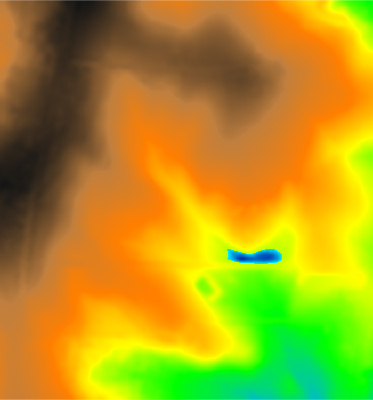

In [37]:
# Create Map instance
floodedarea_map = gj.Map(filename="output/floodedarea.png")\

floodedarea_map.d_rast(map="elev_lid792_1m")
floodedarea_map.d_rast(map="flood1")

# Display map
floodedarea_map.show()

Increase water level to 113.7m and 115.0m and create flooded area maps at these two levels. Include the maps of flooded areas at these water levels in your report. 

   5  11  17  23  29  35  41  47  53  59  65  71  77  83  89  95 100
 100
   5  11  17  23  29  35  41  47  53  59  65  71  77  83  89  95 100
Lake depth from 0.000000 to 9.935738 (specified water level is taken as
zero)
Lake area 81918.000000 square meters
Lake volume 295516.979782 cubic meters
Volume is correct only if lake depth (terrain raster map) is in meters


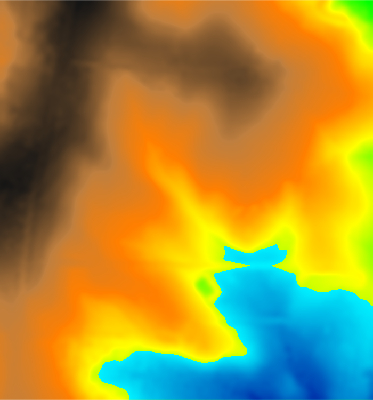

In [38]:
!r.lake elevation=elev_lid792_1m water_level=113.7 lake=flood2 coordinates=638728,220278
# Create Map instance
floodedarea2_map = gj.Map(filename="output/floodedarea2.png")\

floodedarea2_map.d_rast(map="elev_lid792_1m")
floodedarea2_map.d_rast(map="flood2")

# Display map
floodedarea2_map.show()

   5  11  17  23  29  35  41  47  53  59  65  71  77  83  89  95 100
 100
   5  11  17  23  29  35  41  47  53  59  65  71  77  83  89  95 100
Lake depth from 0.000000 to 11.235741 (specified water level is taken as
zero)
Lake area 112176.000000 square meters
Lake volume 425847.237419 cubic meters
Volume is correct only if lake depth (terrain raster map) is in meters


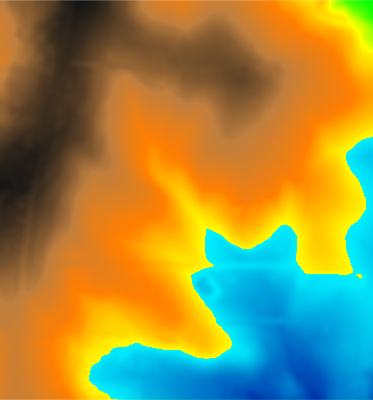

In [39]:
!r.lake elevation=elev_lid792_1m water_level=115.0 lake=flood3 coordinates=638728,220278

# Create Map instance
floodedarea3_map = gj.Map(filename="output/floodedarea3.png")\

floodedarea3_map.d_rast(map="elev_lid792_1m")
floodedarea3_map.d_rast(map="flood3")

# Display map
floodedarea3_map.show()

# 7B - Surface water flow and erosion simulation

## Overland flow depth and discharge

In [40]:
!g.region rural_1m res=2 -p

projection: 99 (Lambert Conformal Conic)
zone:       0
datum:      nad83
ellipsoid:  a=6378137 es=0.006694380022900787
north:      220750
south:      220000
west:       638300
east:       639000
nsres:      2
ewres:      2
rows:       375
cols:       350
cells:      131250


Calculate partial derivatives to define the gradient of elevation surface: 

In [41]:
!v.surf.rst -d input=elev_lid792_bepts elevation=elev_lid792_2m slope=dx_2m aspect=dy_2m tension=15 smooth=1.5 npmin=150

Reading features from vector map ...
WARNING: There are points outside specified 2D/3D region - 95554 points
         ignored
Processing all selected output files will require
1.05 MB of disk space for temp files.
Processing segments in parallel...
Starting parallel work
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
v.surf.rst complete.


Note that partial derivatives can be also computed using `r.slope.aspect`.

Compute spatial pattern of overland flow depth and discharge by running the SIMWE model implemented in the r.sim.water module. We will use uniform rainfall excess, infiltration and land cover. 

In [42]:
!r.sim.water -t elevation=elev_lid792_2m dx=dx_2m dy=dy_2m rain_value=50 infil_value=0 man_value=0.05 depth=wdp_2m discharge=disch_2m nwalkers=100000 niterations=30 output_step=2

Number of threads: 1

Min elevation = 103.89 m
Max elevation = 131.57 m
Mean Source Rate (rainf. excess or sediment) = 0.000014 m/s or kg/m2s
Mean flow velocity = 4.702121 m/s
Mean Mannings = 0.050000
Number of iterations = 4231 cells
Time step = 0.11 s
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 100


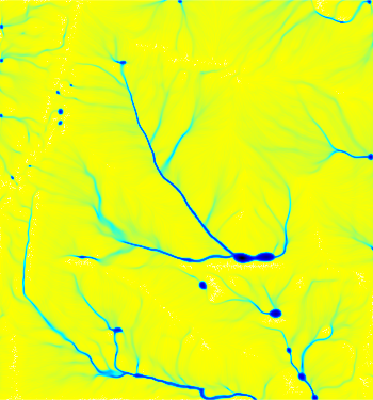

In [46]:
# Create Map instance
wdp_2m_30_map = gj.Map(filename="output/wdp_2m_30.png")
wdp_2m_30_map.d_rast(map="wdp_2m.30")
# Display map
wdp_2m_30_map.show()

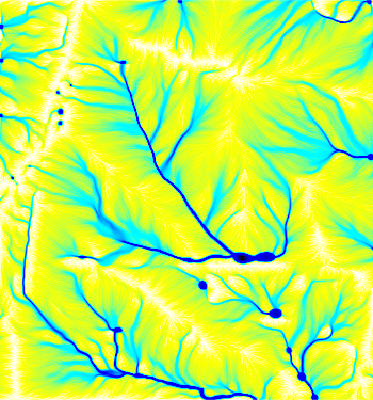

In [47]:
disch_2m_30_map = gj.Map(filename="output/disch_2m_30.png")
disch_2m_30_map.d_rast(map="disch_2m.30")
# Display map
disch_2m_30_map.show()

## Peak runoff with predefined flow direction

Compute peak runoff with predefined flow direction along the stream inluding culvert under the road.

First, compute direction (aspect) of the given streams: 

In [48]:
!v.to.rast streams output=streams_dir_2m use=dir

Reading features...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
v.to.rast complete.


Compute stream dx and dy using direction and slope equal to 2 degrees: 

In [49]:
%%bash
r.mapcalc "dxstr_2m = tan(2.)*cos(streams_dir_2m)"
r.mapcalc "dystr_2m = tan(2.)*sin(streams_dir_2m)"

Compute combined DEM and stream dx and dy: 

In [50]:
%%bash
r.mapcalc "dxdemstr_2m = if(isnull(dxstr_2m), dx_2m, dxstr_2m)"
r.mapcalc "dydemstr_2m = if(isnull(dystr_2m), dy_2m, dystr_2m)"

Run the model: 

In [51]:
%%bash
r.sim.water -t elevation=elev_lid792_2m dx=dxdemstr_2m dy=dydemstr_2m rain_value=50 infil_value=0 man_value=0.05 depth=wdpstr_2m discharge=dischstr_2m nwalkers=100000 niterations=30 output_step=2

Number of threads: 1

Min elevation = 103.89 m
Max elevation = 131.57 m
Mean Source Rate (rainf. excess or sediment) = 0.000014 m/s or kg/m2s
Mean flow velocity = 4.699623 m/s
Mean Mannings = 0.050000
Number of iterations = 4229 cells
Time step = 0.11 s
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 100


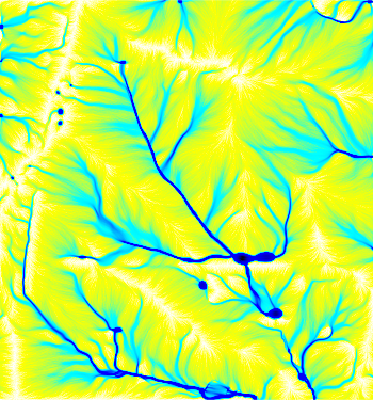

In [52]:
dischstr_2m_30_map = gj.Map(filename="output/dischstr_2m_30.png")
dischstr_2m_30_map.d_rast(map="dischstr_2m.30")
# Display map
dischstr_2m_30_map.show()

## Runoff for spatially variable landcover and rainfall excess

Compute runoff for spatially variable landcover represented by spatially variable Mannings and rainfall excess.

We will use variable Mannings coefficient defined by reclassifying land cover class. Here is the content of a file called land_to_mannings.txt with reclassification rules for the r.recode module. 

In [53]:
!r.recode input=landcover_1m output=mancover_2m rules=inputs/land_to_mannings.txt

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


Similarly, we will create raster with spatially variable rainfall excess rates based on the land cover classes. We use file named land_to_rain.txt to specify the rates for individual classes. 

In [54]:
!r.recode input=landcover_1m output=raincover_2m rules=inputs/land_to_rain.txt

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


Run the model: 

In [55]:
!r.sim.water -t elevation=elev_lid792_2m dx=dxdemstr_2m dy=dydemstr_2m rain=raincover_2m infil_value=0 man=mancover_2m depth=wdpstrcov_2m discharge=distrcov_2m nwalkers=100000 niterations=30 output_step=2

Number of threads: 1

Min elevation = 103.89 m
Max elevation = 131.57 m
Mean Source Rate (rainf. excess or sediment) = 0.000004 m/s or kg/m2s
Mean flow velocity = 1.526391 m/s
Mean Mannings = 0.139552
Number of iterations = 1373 cells
Time step = 0.33 s
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 100


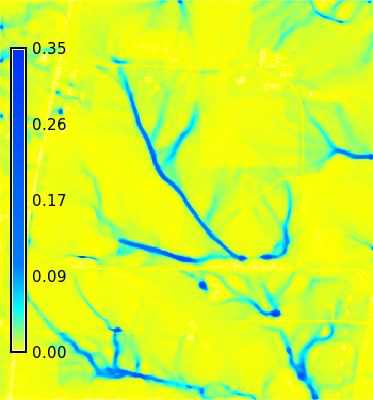

In [57]:
wdpstrcov_2m_30_map = gj.Map(filename="output/wdpstrcov_2m_30.png")
wdpstrcov_2m_30_map.d_rast(map="wdpstrcov_2m.30")
wdpstrcov_2m_30_map.d_legend(raster="wdpstrcov_2m.30")
# Display map
wdpstrcov_2m_30_map.show()

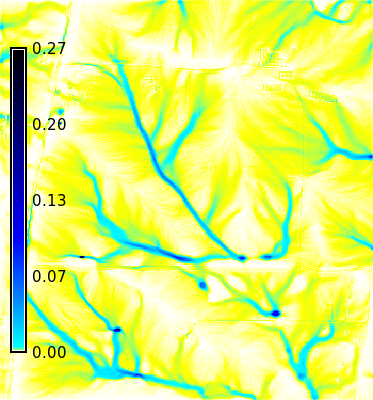

In [58]:
distrcov_2m_30_map = gj.Map(filename="output/distrcov_2m_30.png")
distrcov_2m_30_map.d_rast(map="distrcov_2m.30")
distrcov_2m_30_map.d_legend(raster="distrcov_2m.30")
# Display map
distrcov_2m_30_map.show()

## Sediment flow rate, erosion and deposition

Compute sediment flow rate and net erosion/deposition using sediment transport part of the SIMWE model implemented in the the r.sim.sediment module. To make the computations faster, set region just to the upper part of the watershed: 

In [59]:
!g.region s=s+290

Compute input transport capacity and detachment coefficient maps: 

In [60]:
%%bash
r.mapcalc "tranin = 0.001"
r.mapcalc "detin = 0.001"

Compute input critical shear stress: 

In [61]:
!r.mapcalc "tauin = 0.01"

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


Run the model using the last depth from previous run: 

In [62]:
%%bash
g.copy rast=wdp_2m.30,wdp_2m
r.sim.sediment elevation=elev_lid792_2m dx=dx_2m dy=dy_2m water_depth=wdp_2m detachment_coeff=detin transport_coeff=tranin shear_stress=tauin man_value=0.05 nwalkers=1000000 niterations=30 transport_capacity=tcapacity tlimit_erosion_deposition=erdepmax sediment_flux=sedflow erosion_deposition=erdepsimwe

Copying raster <wdp_2m.30@HW_7A_Flow_Modeling> to current mapset as
<wdp_2m>
Number of threads: 1

Min elevation = 109.42 m
Max elevation = 131.57 m
Mean Source Rate (rainf. excess or sediment) = 0.003515 m/s or kg/m2s
Mean flow velocity = 0.147953 m/s
Mean Mannings = 0.050000
Number of iterations = 426 cells
Time step = 0.12 s
Sigmax = 3.849002
Max velocity = 1.806777 m/s
Time step used = 0.12 s
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 100


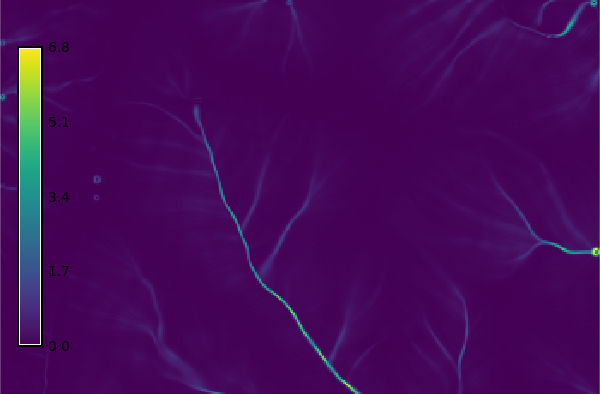

In [63]:
tcapacity_map = gj.Map(filename="output/tcapacity.png")
tcapacity_map.d_rast(map="tcapacity")
tcapacity_map.d_legend(raster="tcapacity")
# Display map
tcapacity_map.show()

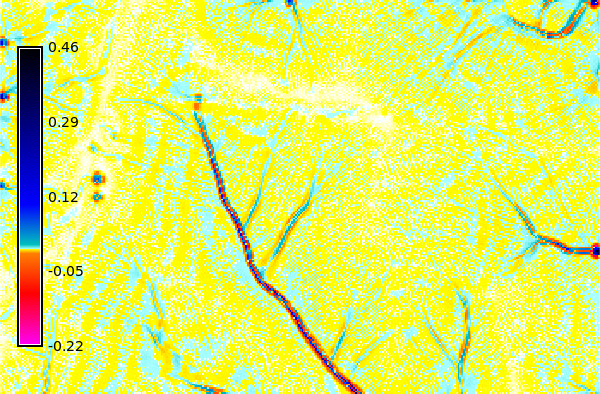

In [64]:
erdepmax_map = gj.Map(filename="output/erdepmax.png")
erdepmax_map.d_rast(map="erdepmax")
erdepmax_map.d_legend(raster="erdepmax")
# Display map
erdepmax_map.show()

 Display the final results: 

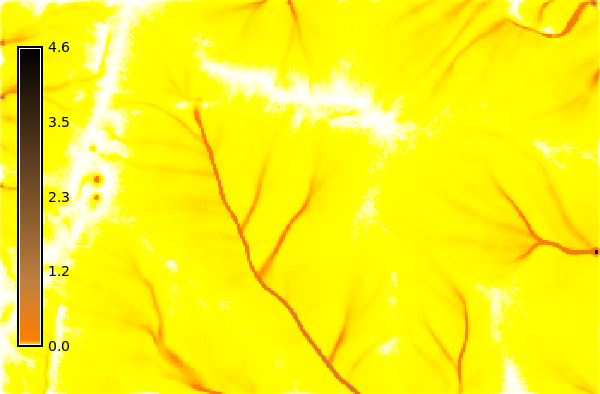

In [65]:
sedflow_map = gj.Map(filename="output/sedflow.png")
sedflow_map.d_rast(map="sedflow")
sedflow_map.d_legend(raster="sedflow")
# Display map
sedflow_map.show()

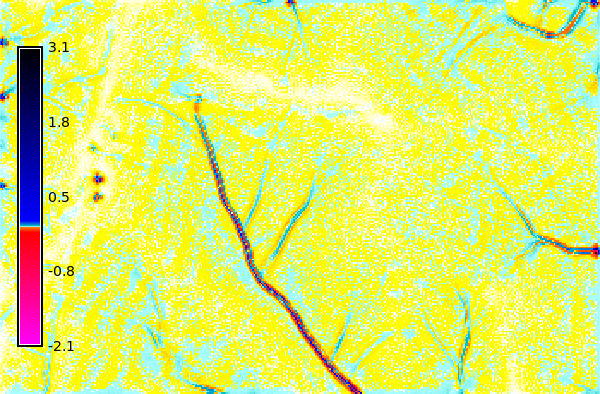

In [66]:
erdepsimwe_map = gj.Map(filename="output/erdepsimwe.png")
erdepsimwe_map.d_rast(map="erdepsimwe")
erdepsimwe_map.d_legend(raster="erdepsimwe")
# Display map
erdepsimwe_map.show()